# 주제
**한 번은 우연, 두 번은 전략: 재방문율 기반 외래관광객 타겟팅 전략**

## 군집화 기준
- 방문객이 많고 재방문율도 높은 나라
- 방문객은 많지만 재방문율이 낮은 나라
- 방문객은 적지만 재방문율이 높은 나라
- 방문객도 적고 재방문율도 낮은 나라

# 군집화 (인구 수 대비 방문객 비율 vs 재방문율)
*국가별 인구수에 따른 방문객 수 - 재방문율로 군집화*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맥북 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### 인구 데이터 병합

In [ ]:
df = pd.read_csv('../data/traveler_data.csv', encoding='cp949')

country_map = {
    1: "중국", 2: "일본", 3: "대만", 4: "미국", 5: "홍콩",
    6: "태국", 7: "베트남", 8: "말레이시아", 9: "필리핀", 10: "싱가포르",
    11: "러시아", 12: "중동", 13: "인도네시아", 14: "캐나다", 15: "호주",
    16: "영국", 17: "몽골", 18: "독일", 19: "프랑스", 20: "인도", 97: "기타"
}
df["국가"] = df["D_NAT"].map(country_map)


# 방문객 수 계산 (weight 합)
size = df.groupby("국가")[["weight"]].sum().rename(columns={"weight": "방문객수"})
size.drop('기타', axis=0, inplace=True) # 기타는 정확한 나라를 모르기 때문에 제거
size

,방문객수
국가,
대만,1325254.46
독일,129618.79
러시아,140431.18
말레이시아,251390.17
몽골,125476.79
미국,1067296.15
베트남,423794.18
싱가포르,320685.75
영국,123436.89


In [2]:
# 인구 데이터프레임: 국가명과 인구수
pop = pd.read_csv('../data/외교부_국가_지역 검색_인구수_스크랩.csv', encoding='cp949')
pop = pop.set_index("국가명")
pop

,인구수(명)
국가명,
대만,23410000
독일,84600000
러시아,145630000
말레이시아,34100000
몽골,3500000
미국,340110000
베트남,101300000
싱가포르,6040000
영국,67020000


In [3]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 대만 to 홍콩
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   인구수(명)  20 non-null     int64
dtypes: int64(1)
memory usage: 320.0+ bytes


In [51]:
# 국가 기준으로 병합
merged = size.join(pop)

# 방문객 비율 (%) 계산
merged["방문객비율"] = (merged["방문객수"] / merged["인구수(명)"]) * 100


In [52]:
merged

,방문객수,인구수(명),방문객비율
국가,,,
대만,1325254.46,23410000,5.661061
독일,129618.79,84600000,0.153214
러시아,140431.18,145630000,0.096430
말레이시아,251390.17,34100000,0.737215
몽골,125476.79,3500000,3.585051
미국,1067296.15,340110000,0.313809
베트남,423794.18,101300000,0.418356
싱가포르,320685.75,6040000,5.309367
영국,123436.89,67020000,0.184179


### 재방문율 변수 생성

In [53]:
repeat = df.groupby("국가").apply(
    lambda x: ((x["D_NUM"] >= 2) * x["weight"]).sum() / x["weight"].sum() * 100
).round(1)
repeat.drop('기타', axis=0, inplace=True)

In [54]:
features = pd.concat([merged["방문객비율"], repeat.rename("재방문율")], axis=1)
features

,방문객비율,재방문율
국가,,
대만,5.661061,56.5
독일,0.153214,33.1
러시아,0.096430,47.2
말레이시아,0.737215,45.1
몽골,3.585051,64.8
미국,0.313809,42.1
베트남,0.418356,34.9
싱가포르,5.309367,59.2
영국,0.184179,40.2


### 표준화

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


## 1. Kmeans Clustering

In [56]:
# KMeans 군집
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
features["Kmeans"] = kmeans.fit_predict(X_scaled)

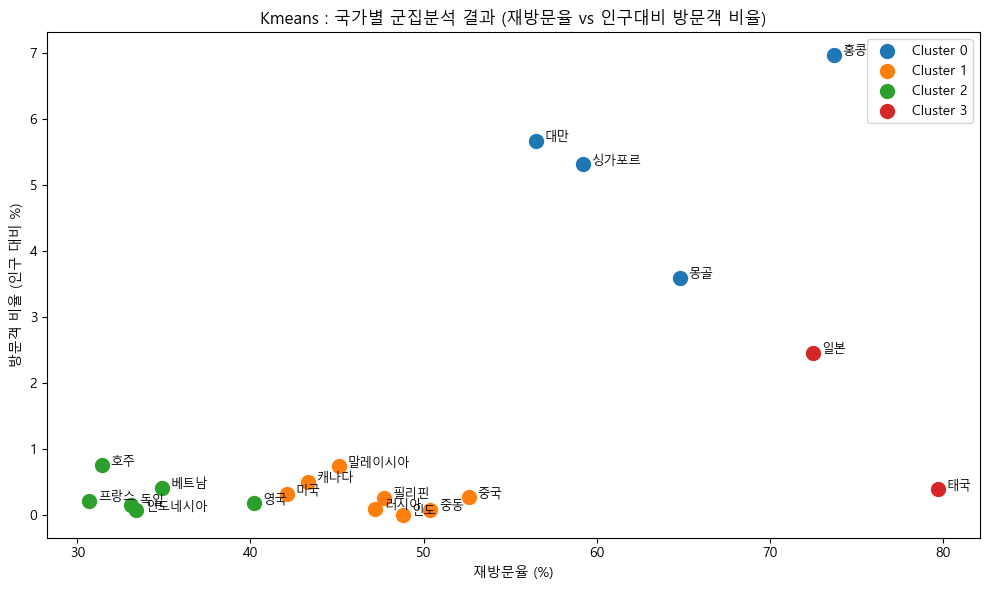

In [71]:
# 시각화

plt.figure(figsize=(10,6))
for c in range(4):
    cluster_countries = features[features["Kmeans"]==c].index
    plt.scatter(
        features.loc[cluster_countries, "재방문율"],
        features.loc[cluster_countries, "방문객비율"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features.loc[name,"재방문율"]+0.5,
            features.loc[name,"방문객비율"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객 비율 (인구 대비 %)")
plt.title("Kmeans : 국가별 군집분석 결과 (재방문율 vs 인구대비 방문객 비율)")
plt.legend()
plt.tight_layout()
plt.show()


## 2. DBSCAN

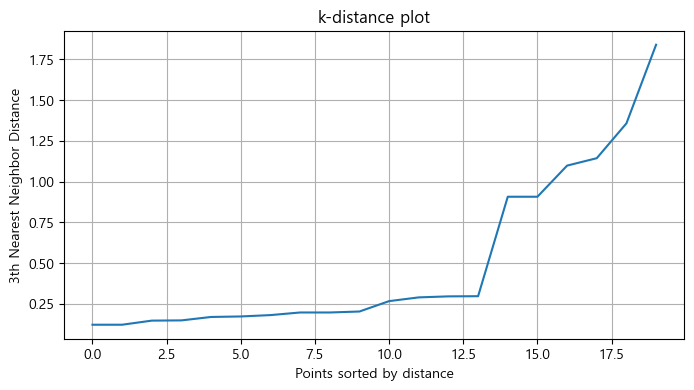

In [70]:
from sklearn.neighbors import NearestNeighbors

# k = min_samples로 설정
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# 각 점의 k번째 이웃 거리만 정렬
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.grid()
plt.show()


In [60]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=3)
features['DBSCAN'] = dbscan.fit_predict(X_scaled)

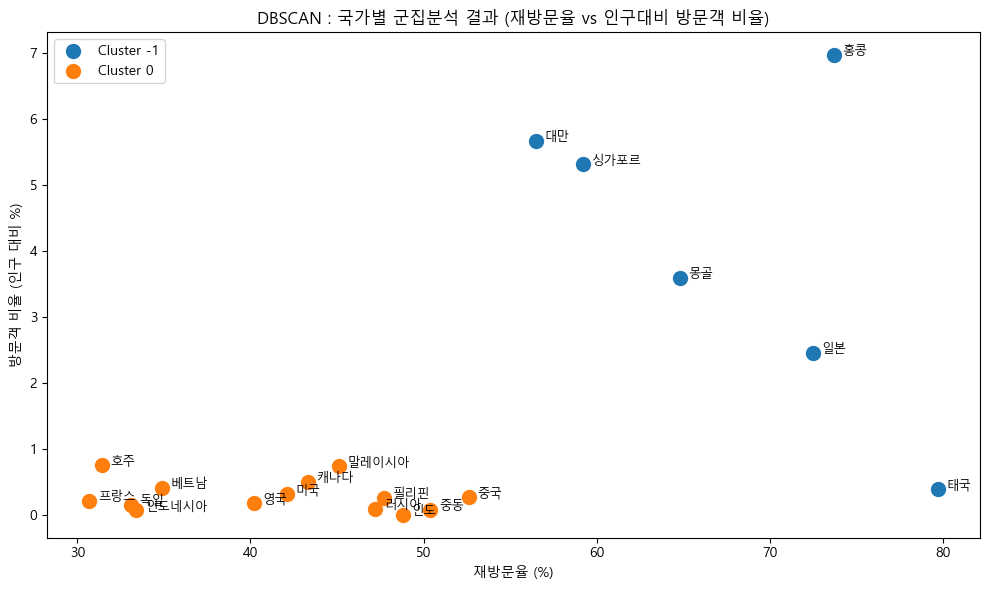

In [78]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(-1, 1):
    cluster_countries = features[features["DBSCAN"]==c].index
    plt.scatter(
        features.loc[cluster_countries, "재방문율"],
        features.loc[cluster_countries, "방문객비율"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features.loc[name,"재방문율"]+0.5,
            features.loc[name,"방문객비율"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객 비율 (인구 대비 %)")
plt.title("DBSCAN : 국가별 군집분석 결과 (재방문율 vs 인구대비 방문객 비율)")
plt.legend()
plt.tight_layout()
plt.show()


## 3. Hierarchical Clustering

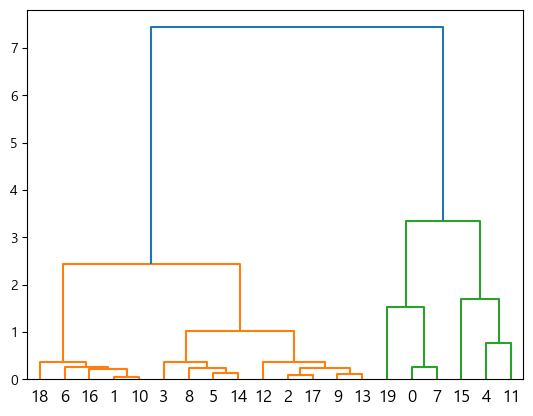

In [62]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_scaled, method='ward')
dendrogram(Z)
# 군집 할당
features['Hcluster'] = fcluster(Z, t=4, criterion='maxclust')


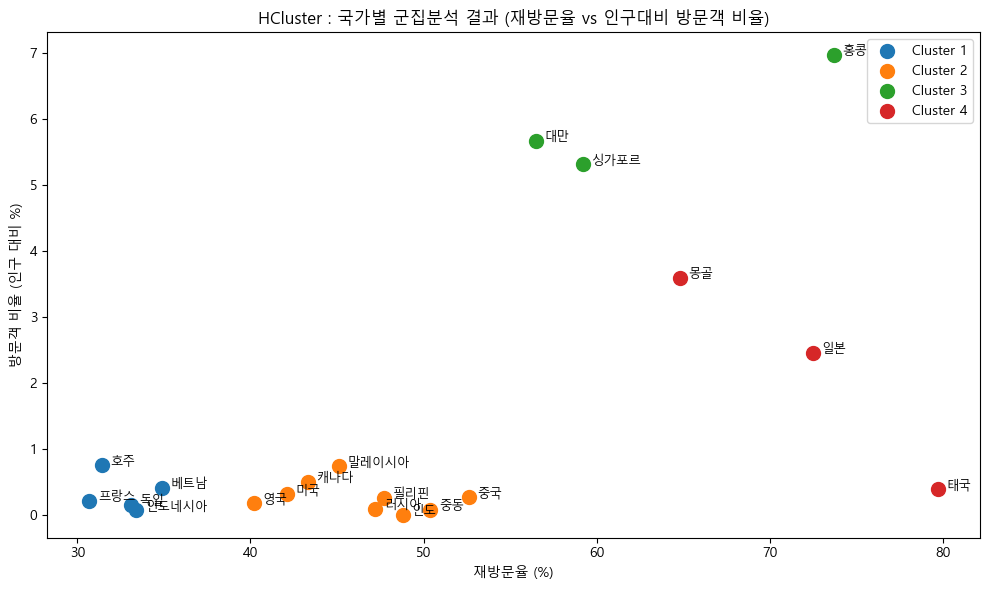

In [79]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(1,5):
    cluster_countries = features[features["Hcluster"]==c].index
    plt.scatter(
        features.loc[cluster_countries, "재방문율"],
        features.loc[cluster_countries, "방문객비율"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features.loc[name,"재방문율"]+0.5,
            features.loc[name,"방문객비율"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객 비율 (인구 대비 %)")
plt.title("HCluster : 국가별 군집분석 결과 (재방문율 vs 인구대비 방문객 비율)")
plt.legend()
plt.tight_layout()
plt.show()


## 4. GMM

In [73]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
features['GMM'] = gmm.fit_predict(X_scaled)


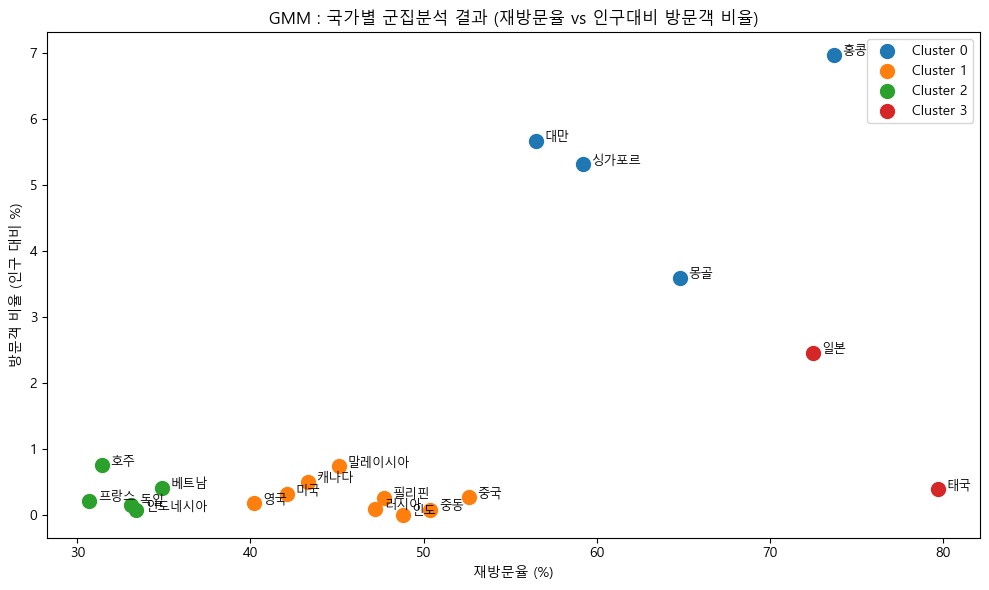

In [77]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(4):
    cluster_countries = features[features["GMM"]==c].index
    plt.scatter(
        features.loc[cluster_countries, "재방문율"],
        features.loc[cluster_countries, "방문객비율"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features.loc[name,"재방문율"]+0.5,
            features.loc[name,"방문객비율"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객 비율 (인구 대비 %)")
plt.title("GMM : 국가별 군집분석 결과 (재방문율 vs 인구대비 방문객 비율)")
plt.legend()
plt.tight_layout()
plt.show()


# 군집화 (방문객 수 vs 재방문율)
*방문객 수 - 재방문율로 군집화*

### 인구 데이터 병합

In [83]:
df = pd.read_csv('../data/traveler_data.csv', encoding='cp949')

country_map = {
    1: "중국", 2: "일본", 3: "대만", 4: "미국", 5: "홍콩",
    6: "태국", 7: "베트남", 8: "말레이시아", 9: "필리핀", 10: "싱가포르",
    11: "러시아", 12: "중동", 13: "인도네시아", 14: "캐나다", 15: "호주",
    16: "영국", 17: "몽골", 18: "독일", 19: "프랑스", 20: "인도", 97: "기타"
}
df["국가"] = df["D_NAT"].map(country_map)


# 방문객 수 계산 (weight 합)
size = df.groupby("국가")[["weight"]].sum().rename(columns={"weight": "방문객수"})
size.drop('기타', axis=0, inplace=True) # 기타는 정확한 나라를 모르기 때문에 제거
size

,방문객수
국가,
대만,1325254.46
독일,129618.79
러시아,140431.18
말레이시아,251390.17
몽골,125476.79
미국,1067296.15
베트남,423794.18
싱가포르,320685.75
영국,123436.89


### 재방문율 변수 생성

In [84]:
repeat = df.groupby("국가").apply(
    lambda x: ((x["D_NUM"] >= 2) * x["weight"]).sum() / x["weight"].sum() * 100
).round(1)
repeat.drop('기타', axis=0, inplace=True)

In [85]:
features2 = pd.concat([size["방문객수"], repeat.rename("재방문율")], axis=1)
features2

,방문객수,재방문율
국가,,
대만,1325254.46,56.5
독일,129618.79,33.1
러시아,140431.18,47.2
말레이시아,251390.17,45.1
몽골,125476.79,64.8
미국,1067296.15,42.1
베트남,423794.18,34.9
싱가포르,320685.75,59.2
영국,123436.89,40.2


### 표준화

In [86]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features2)


## 1. Kmeans Clustering

In [95]:
# KMeans 군집
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
features2["Kmeans"] = kmeans.fit_predict(X_scaled)

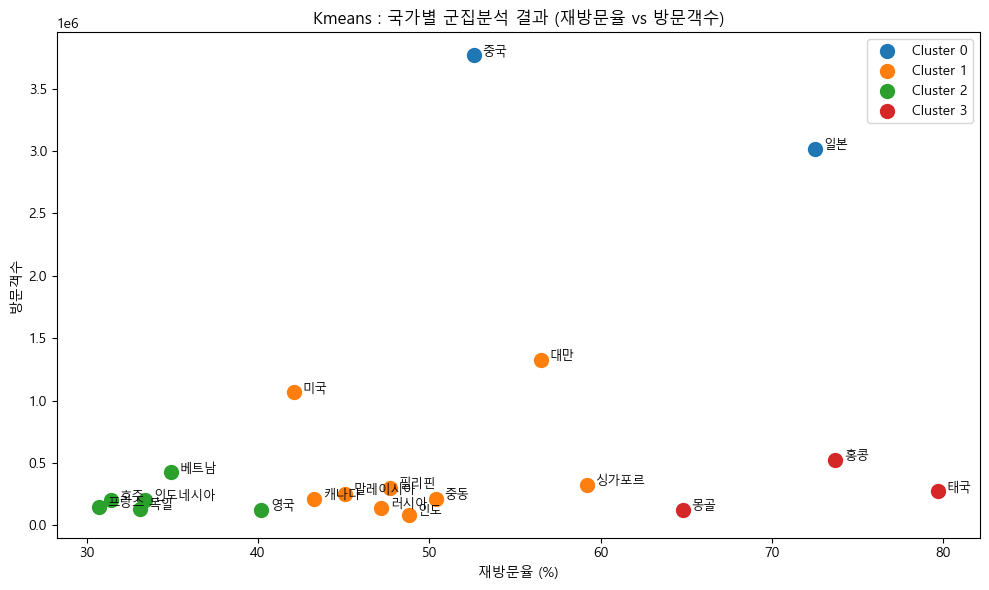

In [96]:
# 시각화

plt.figure(figsize=(10,6))
for c in range(4):
    cluster_countries = features2[features2["Kmeans"]==c].index
    plt.scatter(
        features2.loc[cluster_countries, "재방문율"],
        features2.loc[cluster_countries, "방문객수"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features2.loc[name,"재방문율"]+0.5,
            features2.loc[name,"방문객수"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객수")
plt.title("Kmeans : 국가별 군집분석 결과 (재방문율 vs 방문객수)")
plt.legend()
plt.tight_layout()
plt.show()


## 2. DBSCAN

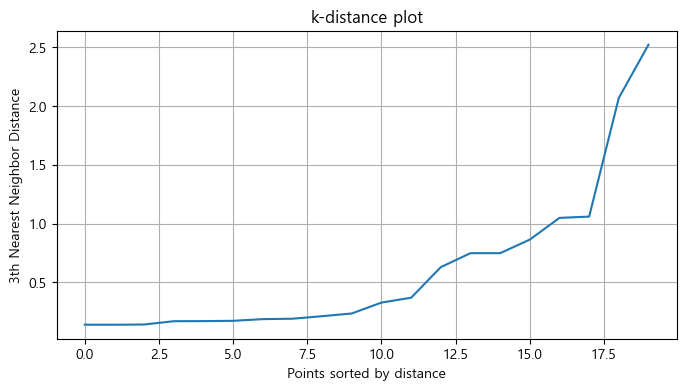

In [97]:
from sklearn.neighbors import NearestNeighbors

# k = min_samples로 설정
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# 각 점의 k번째 이웃 거리만 정렬
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.grid()
plt.show()


In [104]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.1, min_samples=3)
features2['DBSCAN'] = dbscan.fit_predict(X_scaled)

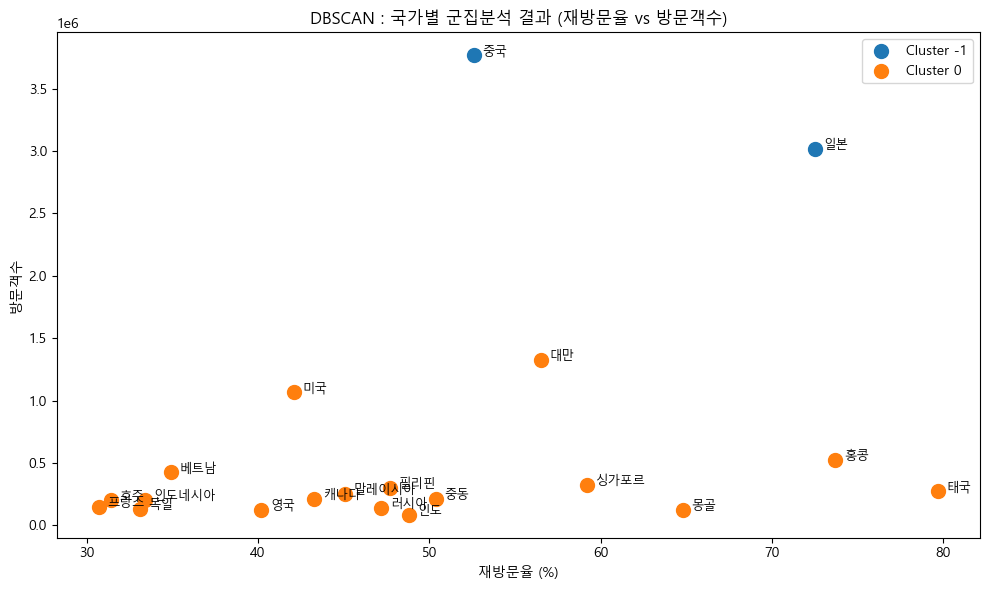

In [105]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(-1, 1):
    cluster_countries = features2[features2["DBSCAN"]==c].index
    plt.scatter(
        features2.loc[cluster_countries, "재방문율"],
        features2.loc[cluster_countries, "방문객수"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features2.loc[name,"재방문율"]+0.5,
            features2.loc[name,"방문객수"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객수")
plt.title("DBSCAN : 국가별 군집분석 결과 (재방문율 vs 방문객수)")
plt.legend()
plt.tight_layout()
plt.show()


## 3. Hierarchical Clustering

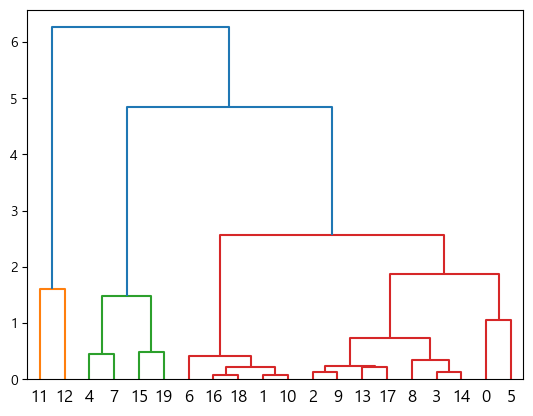

In [100]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_scaled, method='ward')
dendrogram(Z)
# 군집 할당
features2['Hcluster'] = fcluster(Z, t=4, criterion='maxclust')


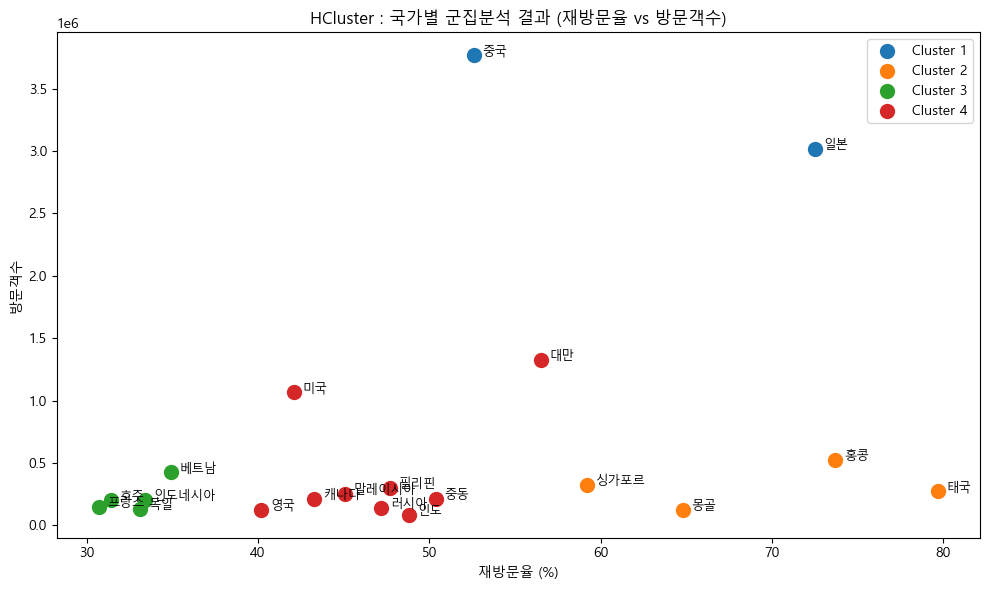

In [101]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(1,5):
    cluster_countries = features2[features2["Hcluster"]==c].index
    plt.scatter(
        features2.loc[cluster_countries, "재방문율"],
        features2.loc[cluster_countries, "방문객수"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features2.loc[name,"재방문율"]+0.5,
            features2.loc[name,"방문객수"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객수")
plt.title("HCluster : 국가별 군집분석 결과 (재방문율 vs 방문객수)")
plt.legend()
plt.tight_layout()
plt.show()


## 4. GMM

In [102]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
features2['GMM'] = gmm.fit_predict(X_scaled)


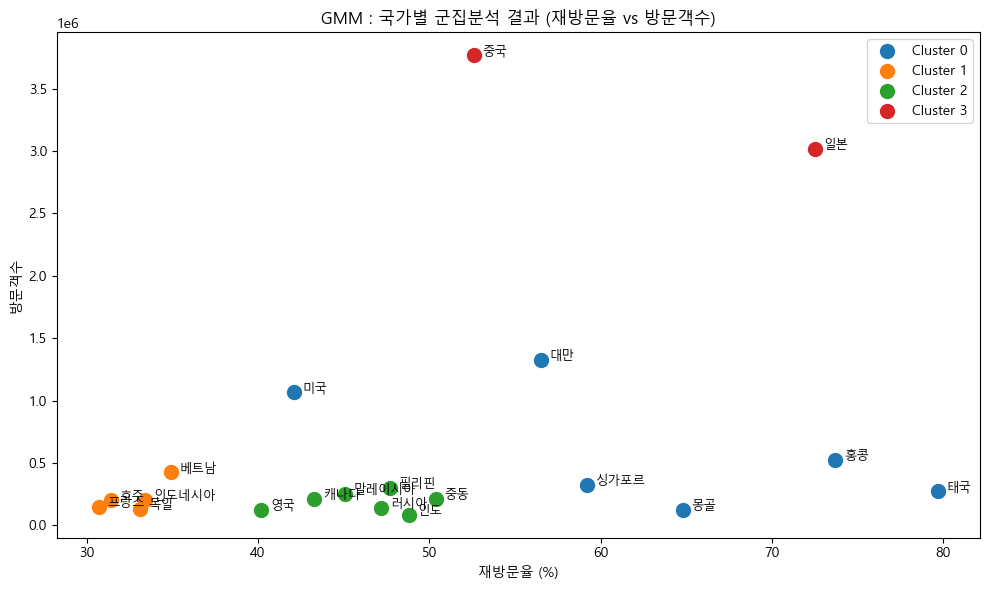

In [103]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(4):
    cluster_countries = features2[features2["GMM"]==c].index
    plt.scatter(
        features2.loc[cluster_countries, "재방문율"],
        features2.loc[cluster_countries, "방문객수"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features2.loc[name,"재방문율"]+0.5,
            features2.loc[name,"방문객수"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객수")
plt.title("GMM : 국가별 군집분석 결과 (재방문율 vs 방문객수)")
plt.legend()
plt.tight_layout()
plt.show()
